In [125]:
#Import Libraries
import math
import numpy as np
import pandas
from scipy.io import loadmat
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
from keras import backend as K
plt.style.use('fivethirtyeight')

In [126]:
# loads matlab files data into a python dict
mat_data = loadmat('TRAIN_LGHG2@n10degC_to_25degC_Norm_5Inputs.mat')

#Test data set
test_data = loadmat('04_TEST_LGHG2@25degC_Norm_(05_Inputs).mat')

In [127]:
# extracts the first 3 rows (Voltage, Current, Temp) and 100000 columns from the "X" key
x_train = mat_data["X"][:3,:600000] 
# extracts the first 100000 columns from the "Y" (SOC) key
y_train = mat_data["Y"][:1,:600000] 

#Create the x_test and y_test data sets
x_test = test_data["X"][:3,:40000]
y_test = test_data["Y"][:1,:40000]

In [128]:
# flips columns and rows so data is proper shape, have the same # of input features
x_train = x_train.T
y_train = y_train.T
x_test = x_test.T
y_test = y_test.T

In [129]:
#Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train),np.array(y_train)
x_test, y_test = np.array(x_test),np.array(y_test)

In [130]:
#Reshape the data
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

In [131]:
num_responses = 1
num_features = 3
num_hidden_units = 10
epochs = 100
batch_size = x_test.shape[0]
learn_rate_drop_period = 2000
LearningRate = 0.01
learn_rate_drop_factor = 0.5

In [132]:
#Build the LSTM model 
#def buildModel():
model = Sequential()
model.add(LSTM(10, batch_input_shape=(batch_size, x_train.shape[1],1), stateful=True,return_sequences=False))
model.add(Dense(10))
model.add(tf.keras.layers.ReLU(max_value=1))
model.add(Dense(1))
model.summary()


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (40000, 10)               480       
                                                                 
 dense_18 (Dense)            (40000, 10)               110       
                                                                 
 re_lu_9 (ReLU)              (40000, 10)               0         
                                                                 
 dense_19 (Dense)            (40000, 1)                11        
                                                                 
Total params: 601
Trainable params: 601
Non-trainable params: 0
_________________________________________________________________


In [133]:
#Define the learning rate scheduler
def scheduler(epoch, lr):
    if epoch % learn_rate_drop_period == 0 and epoch:
        return lr * learn_rate_drop_factor
    else:
        return lr

#Define the learning rate scheduler callback
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [134]:
#Compile the model with a learning rate scheduler
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LearningRate), loss='mean_squared_error')

#Train the model
model.fit(x_train,y_train, batch_size=batch_size, epochs=epochs, callbacks=[lr_scheduler],validation_data=(x_test, y_test),)
# added validation data

Epoch 1/100
15/15 [==============================] - 4s 108ms/step - loss: 0.2787 - val_loss: 0.1471 - lr: 0.0100
Epoch 2/100
15/15 [==============================] - 1s 62ms/step - loss: 0.1334 - val_loss: 0.0903 - lr: 0.0100
Epoch 3/100
15/15 [==============================] - 1s 67ms/step - loss: 0.1150 - val_loss: 0.0803 - lr: 0.0100
Epoch 4/100
15/15 [==============================] - 1s 70ms/step - loss: 0.1117 - val_loss: 0.0777 - lr: 0.0100
Epoch 5/100
15/15 [==============================] - 1s 62ms/step - loss: 0.1097 - val_loss: 0.0763 - lr: 0.0100
Epoch 6/100
15/15 [==============================] - 1s 61ms/step - loss: 0.1084 - val_loss: 0.0756 - lr: 0.0100
Epoch 7/100
15/15 [==============================] - 1s 64ms/step - loss: 0.1065 - val_loss: 0.0743 - lr: 0.0100
Epoch 8/100
15/15 [==============================] - 1s 62ms/step - loss: 0.1036 - val_loss: 0.0717 - lr: 0.0100
Epoch 9/100
15/15 [==============================] - 1s 64ms/step - loss: 0.0976 - val_loss: 0.

In [141]:
#make predictions Stateful = True
trainPredict = model.predict(x_train, batch_size=batch_size)
# model.reset_states()
testPredict = model.predict(x_test, batch_size=batch_size)
# model.reset_states()

1/1 [==============================] - 0s 58ms/step


In [142]:
#Get the root mean squared error (RMSE)
rmse_train= np.sqrt(np.mean(((trainPredict- y_train)**2)))*100
rmse_train

3.5907701432131387

In [143]:
#Get the root mean squared error (RMSE)
rmse_test= np.sqrt(np.mean(((testPredict- y_test)**2)))*100
rmse_test

3.290201670839471

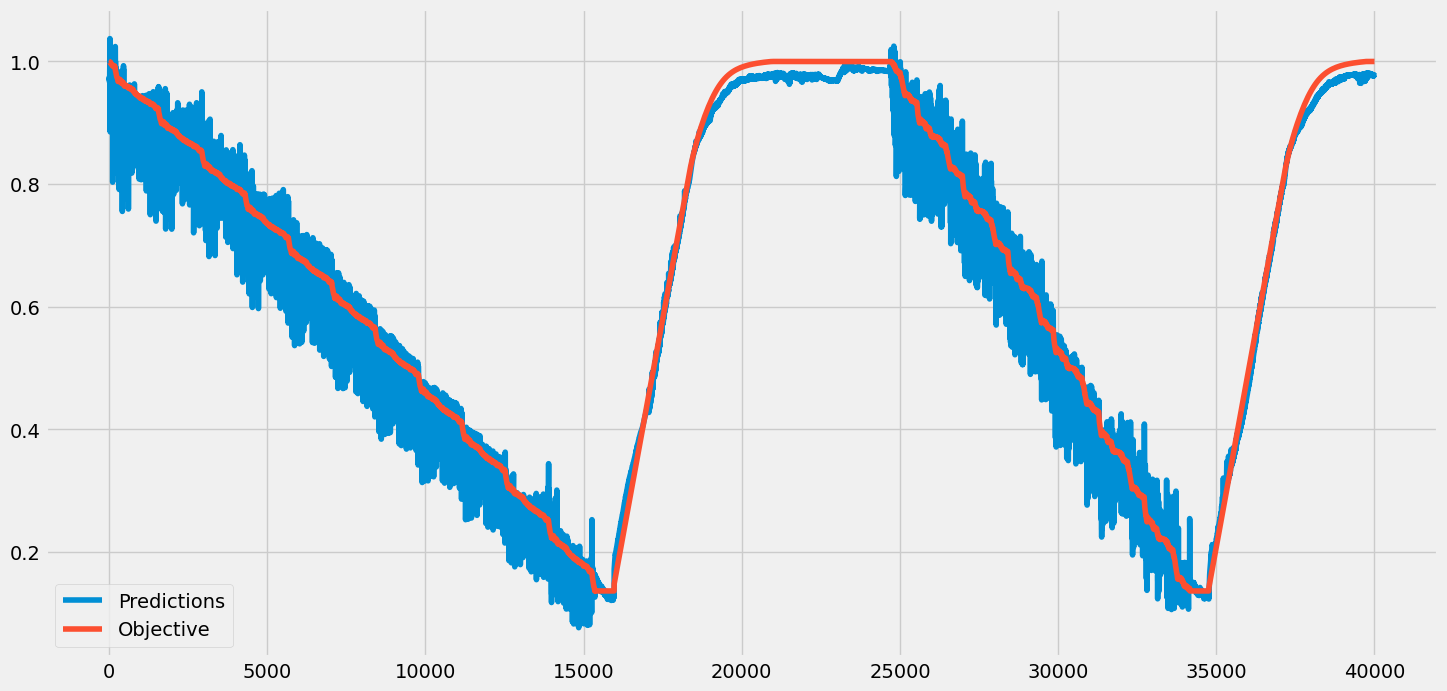

In [148]:
plt.figure(figsize=(16,8))

# Plot the predictions
plt.plot(testPredict, label="Predictions")
# Plot the true values
plt.plot(y_test, label="Objective")
# Add a legend
plt.legend()
# Show the plot
plt.show()

In [147]:
#save the model
model.save('LSTM_Model.h5')